In [1]:
import warnings
warnings.simplefilter(action ="ignore")
warnings.filterwarnings("ignore")

from collections import Counter
import joblib

# Import the necessary packages
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

# Data directory
import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<h1>**Maternal Health Risk Data**<h1>

In [2]:
m_df = pd.read_csv("Maternal Health Risk Data Set.csv")
m_df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
print(f"The dataset size: {m_df.shape}")

The dataset size: (1014, 7)


In [5]:
print(m_df["RiskLevel"].value_counts())

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


In [6]:
m_df.tail()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk
1013,32,120,65,6.0,101.0,76,mid risk


In [7]:
m_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


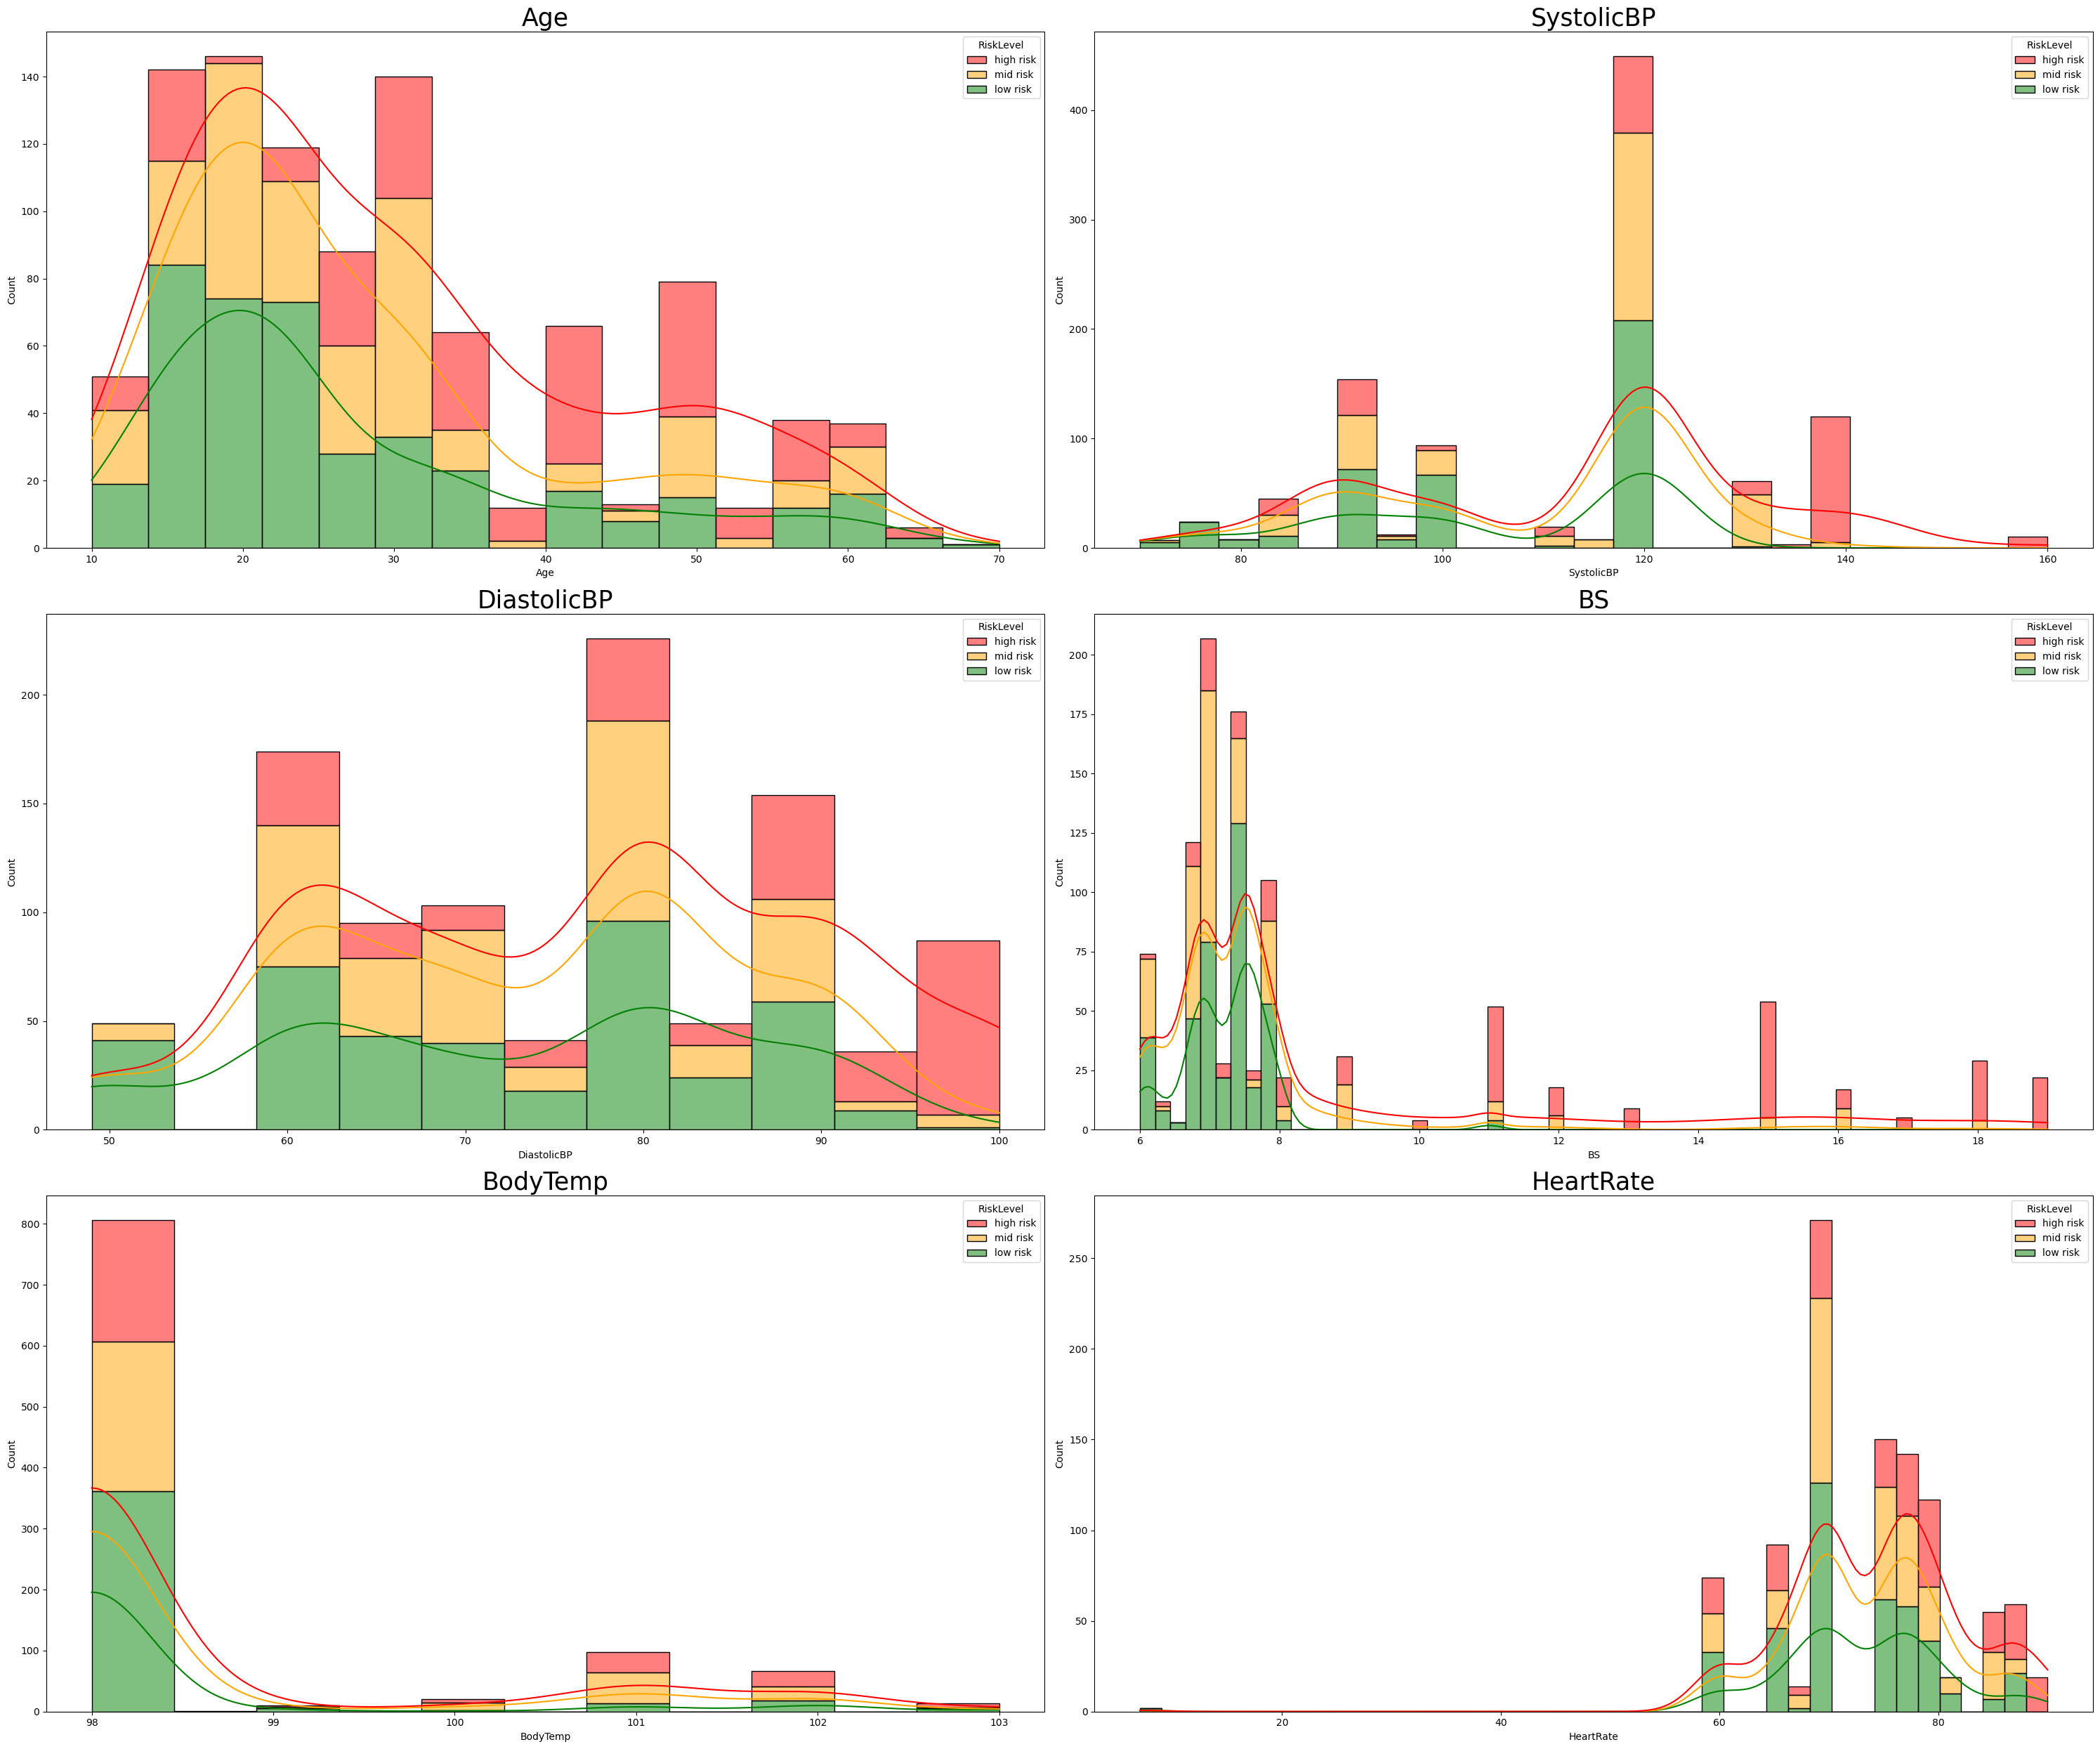

In [8]:
# Plot stacked histograms for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 25))
risk_level_order = ["high risk", "mid risk", "low risk"]

for ax, column in zip(axes.flatten(), m_df.columns):
    sns.histplot(data=m_df, 
                 x=column, 
                 kde=True, 
                 hue="RiskLevel", 
                 hue_order=risk_level_order, 
                 multiple="stack",
                 palette={"low risk": "green", "mid risk": "orange", "high risk": "red"},
                 element="bars", ax=ax)
    ax.set_title(f"{column}", fontsize=25)

plt.tight_layout()
plt.savefig("maternal_features_description.png")
plt.show()

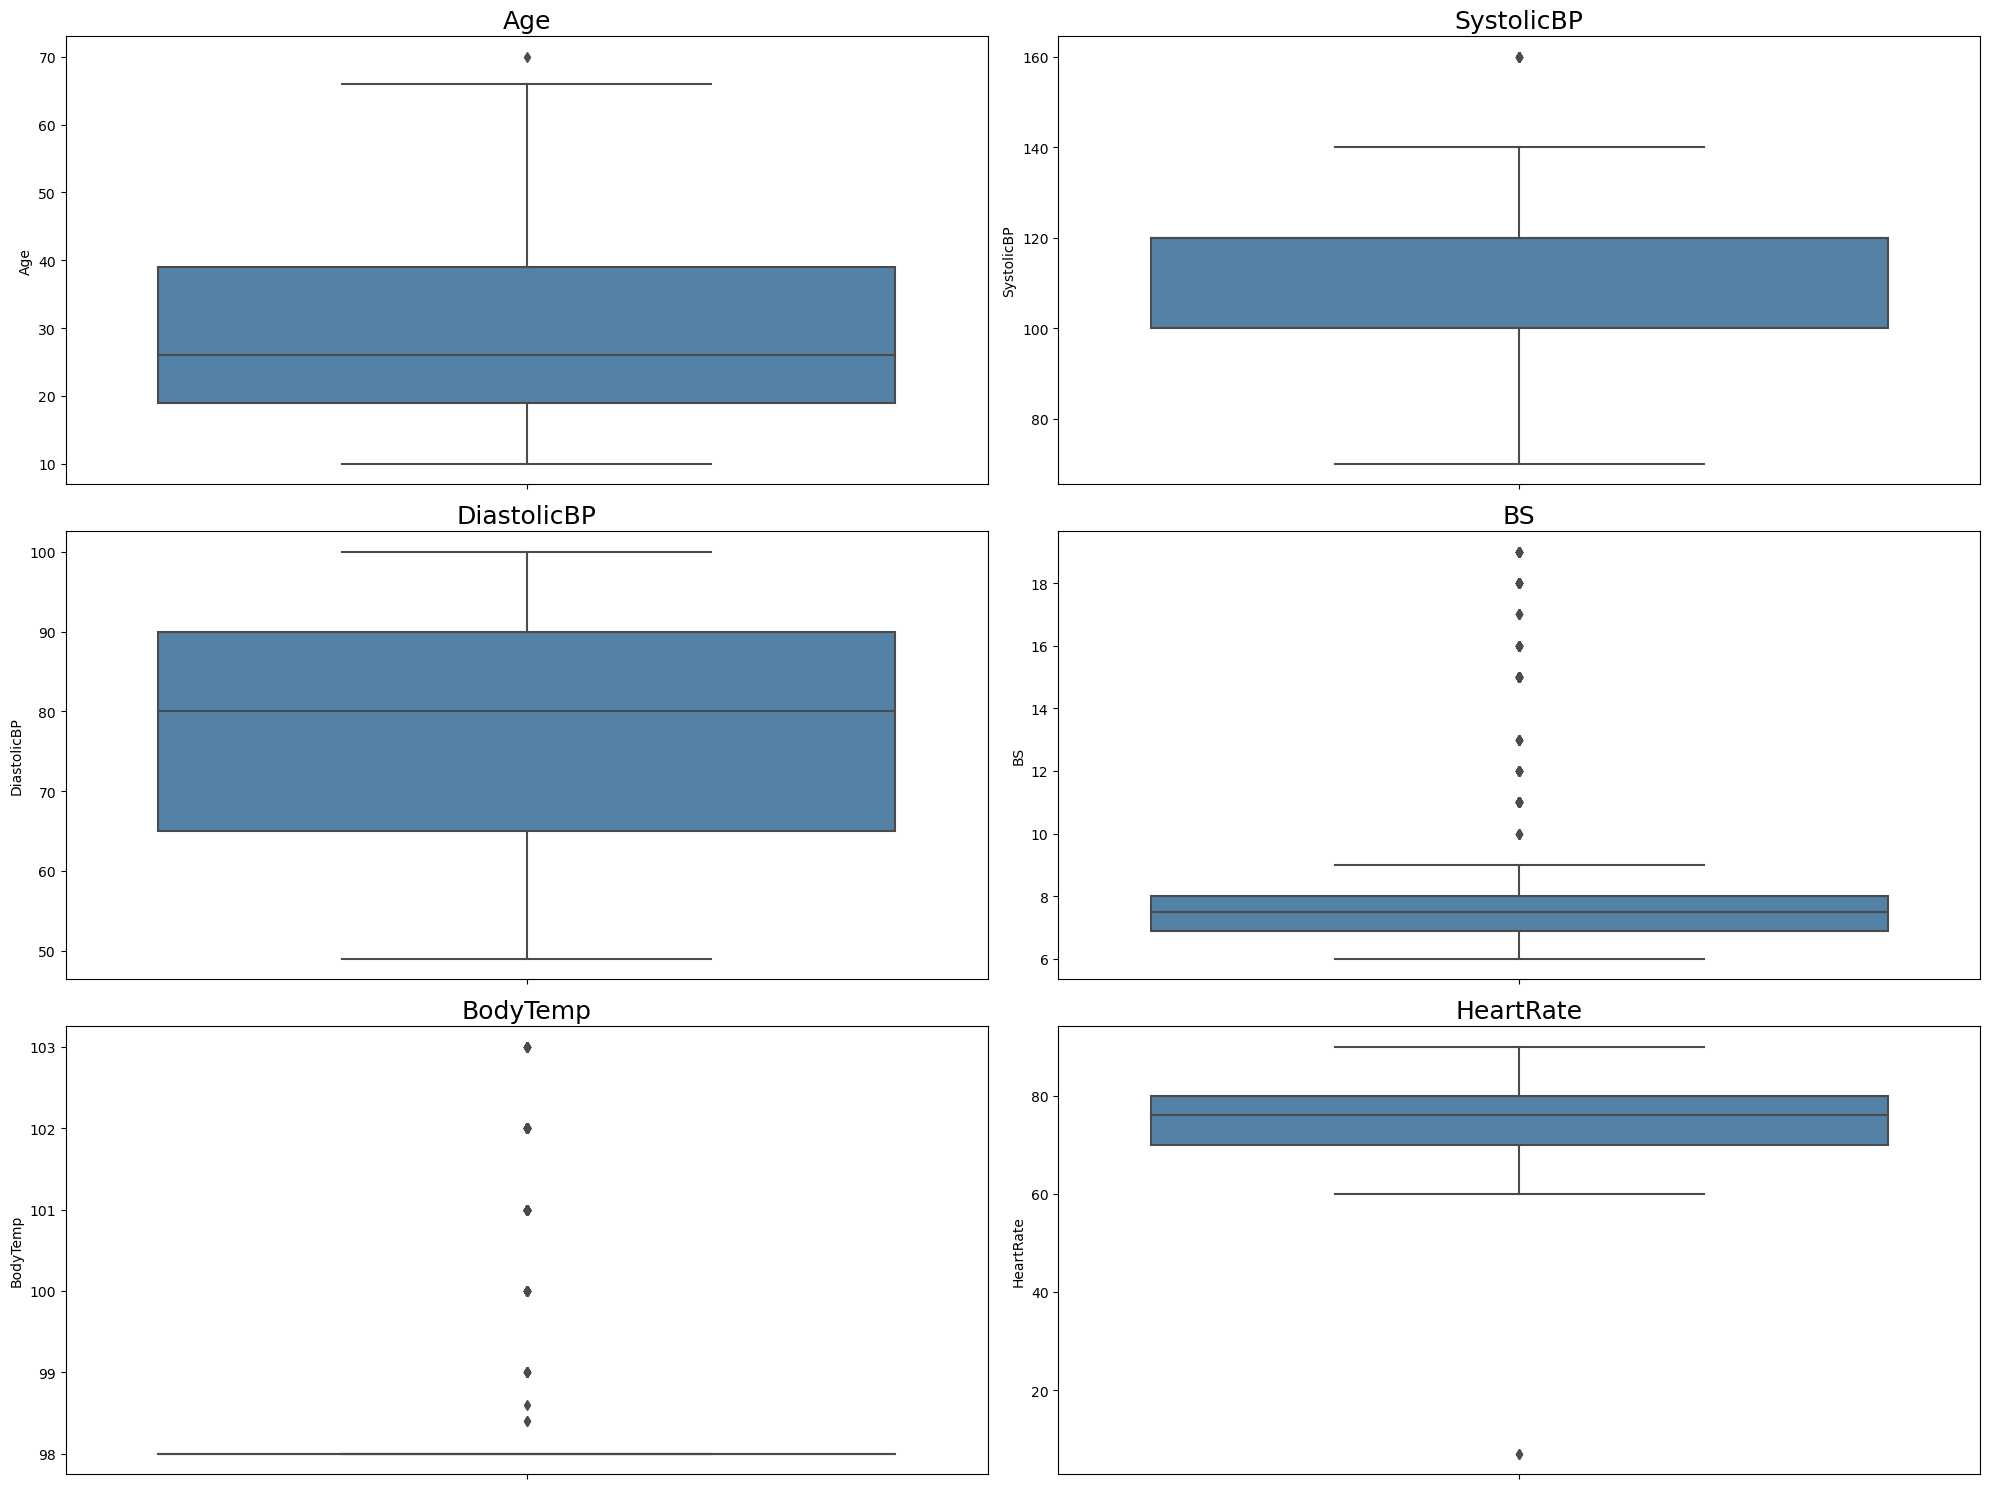

In [9]:
# Plot boxplots for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

for ax, column in zip(axes.flatten(), m_df.columns):
    sns.boxplot(y=m_df[column], 
                color="#4682B4", 
                ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.savefig("materanl_skewed_distribution_to_check_outliars.png")
plt.show()

<h3>Correlation Analysis of Variables</h3>

In [10]:
# Map RiskLevel to integer values
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
m_df["RiskLevel"] = m_df["RiskLevel"].map(risk_mapping)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


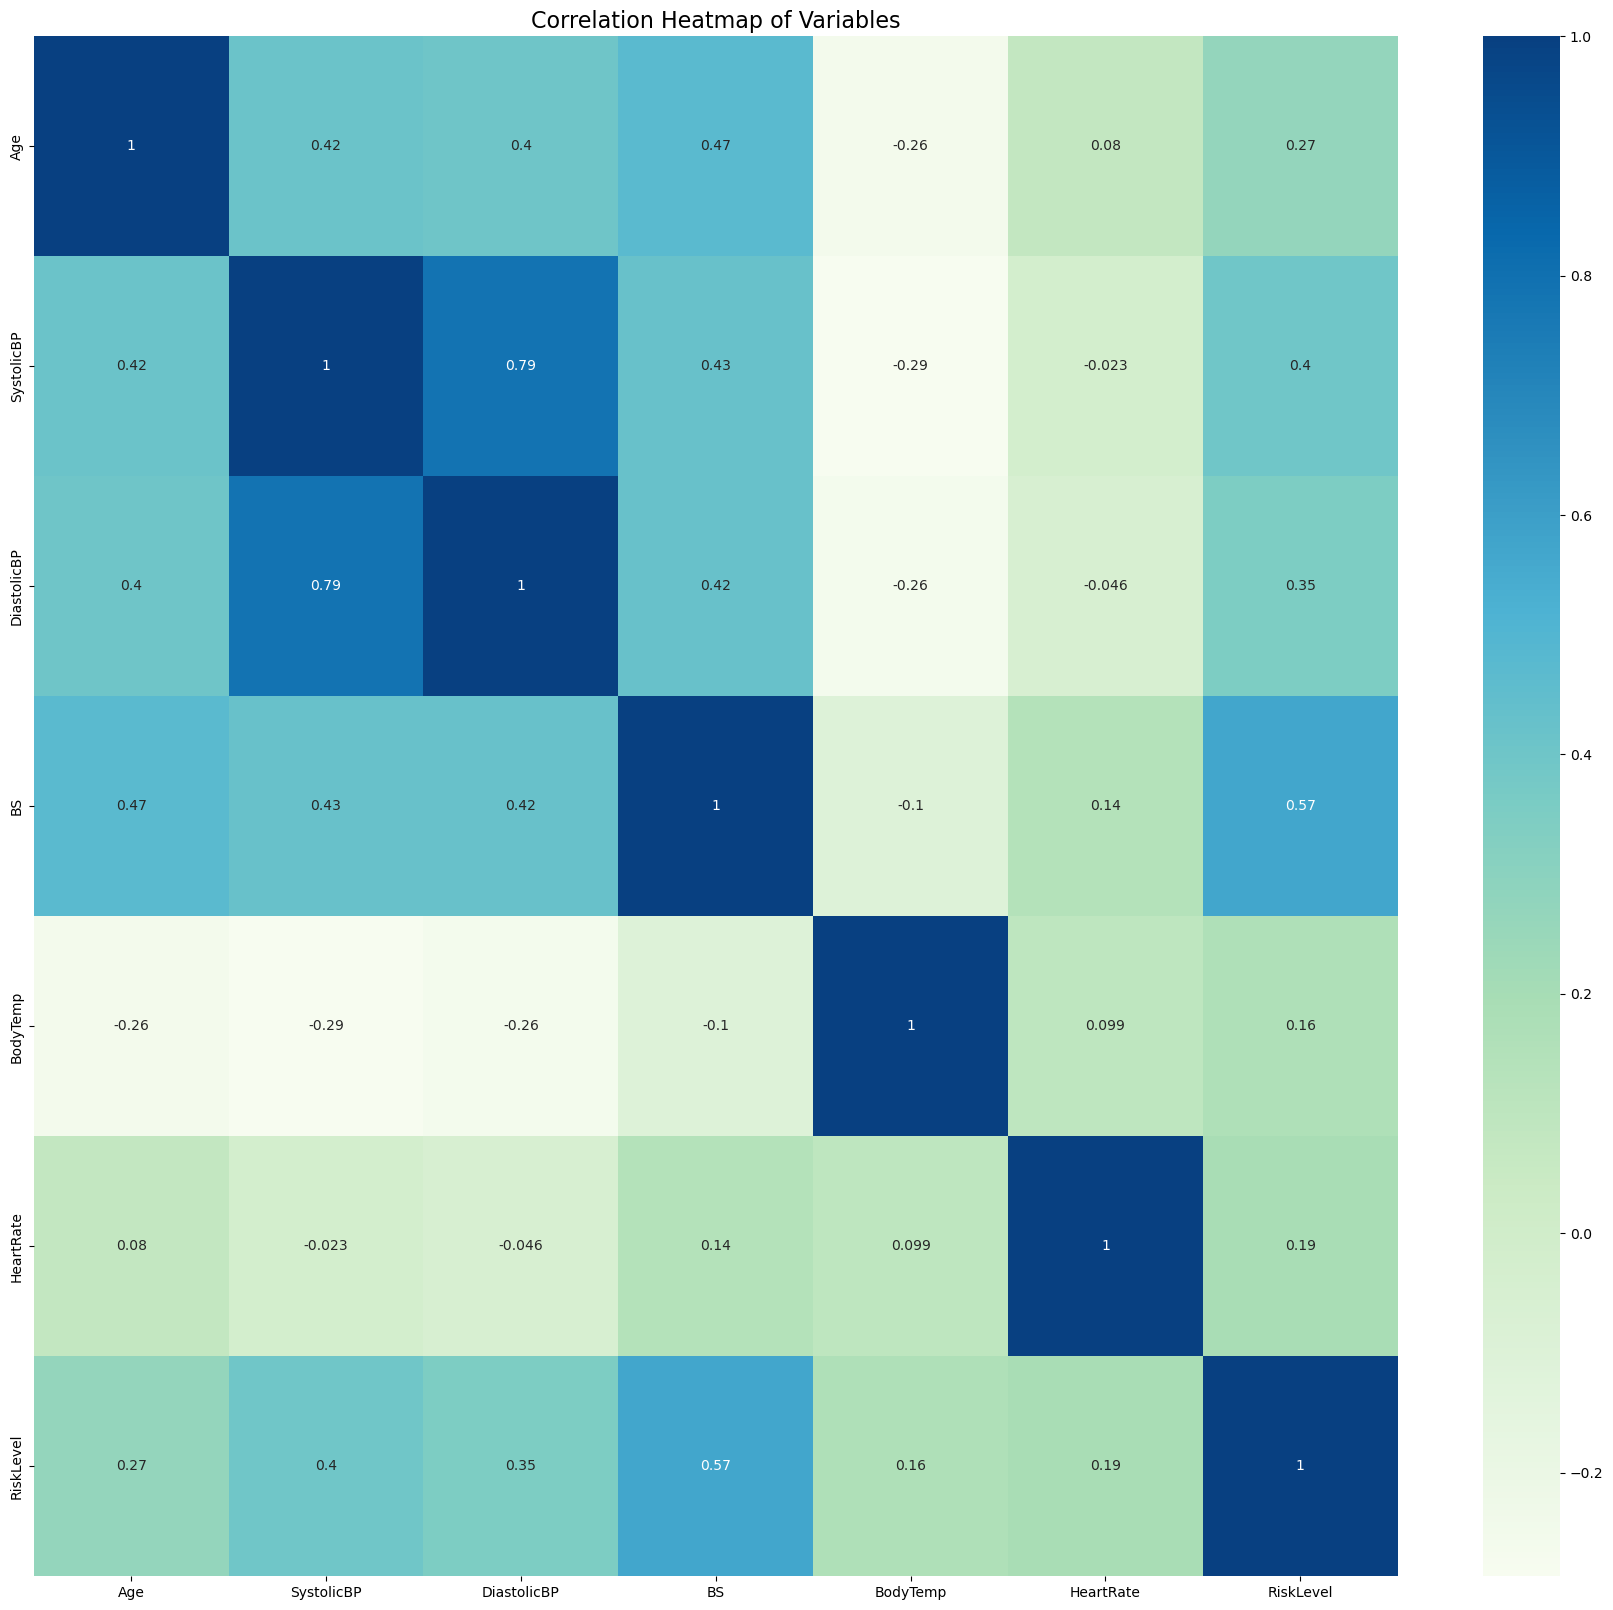

In [11]:
# Create a correlation heatmap
plt.figure(figsize=(22,20))  
sns.heatmap(m_df.corr(), annot=True, cmap = "GnBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.savefig("maternal_heat_map_to_check_correlation.png")
plt.show()

SystolicBP and DiastolicBP show a high positive correlation (correlation coefficient = 0.79), indicating multicollinearity. This suggests redundancy in information between these two variables.

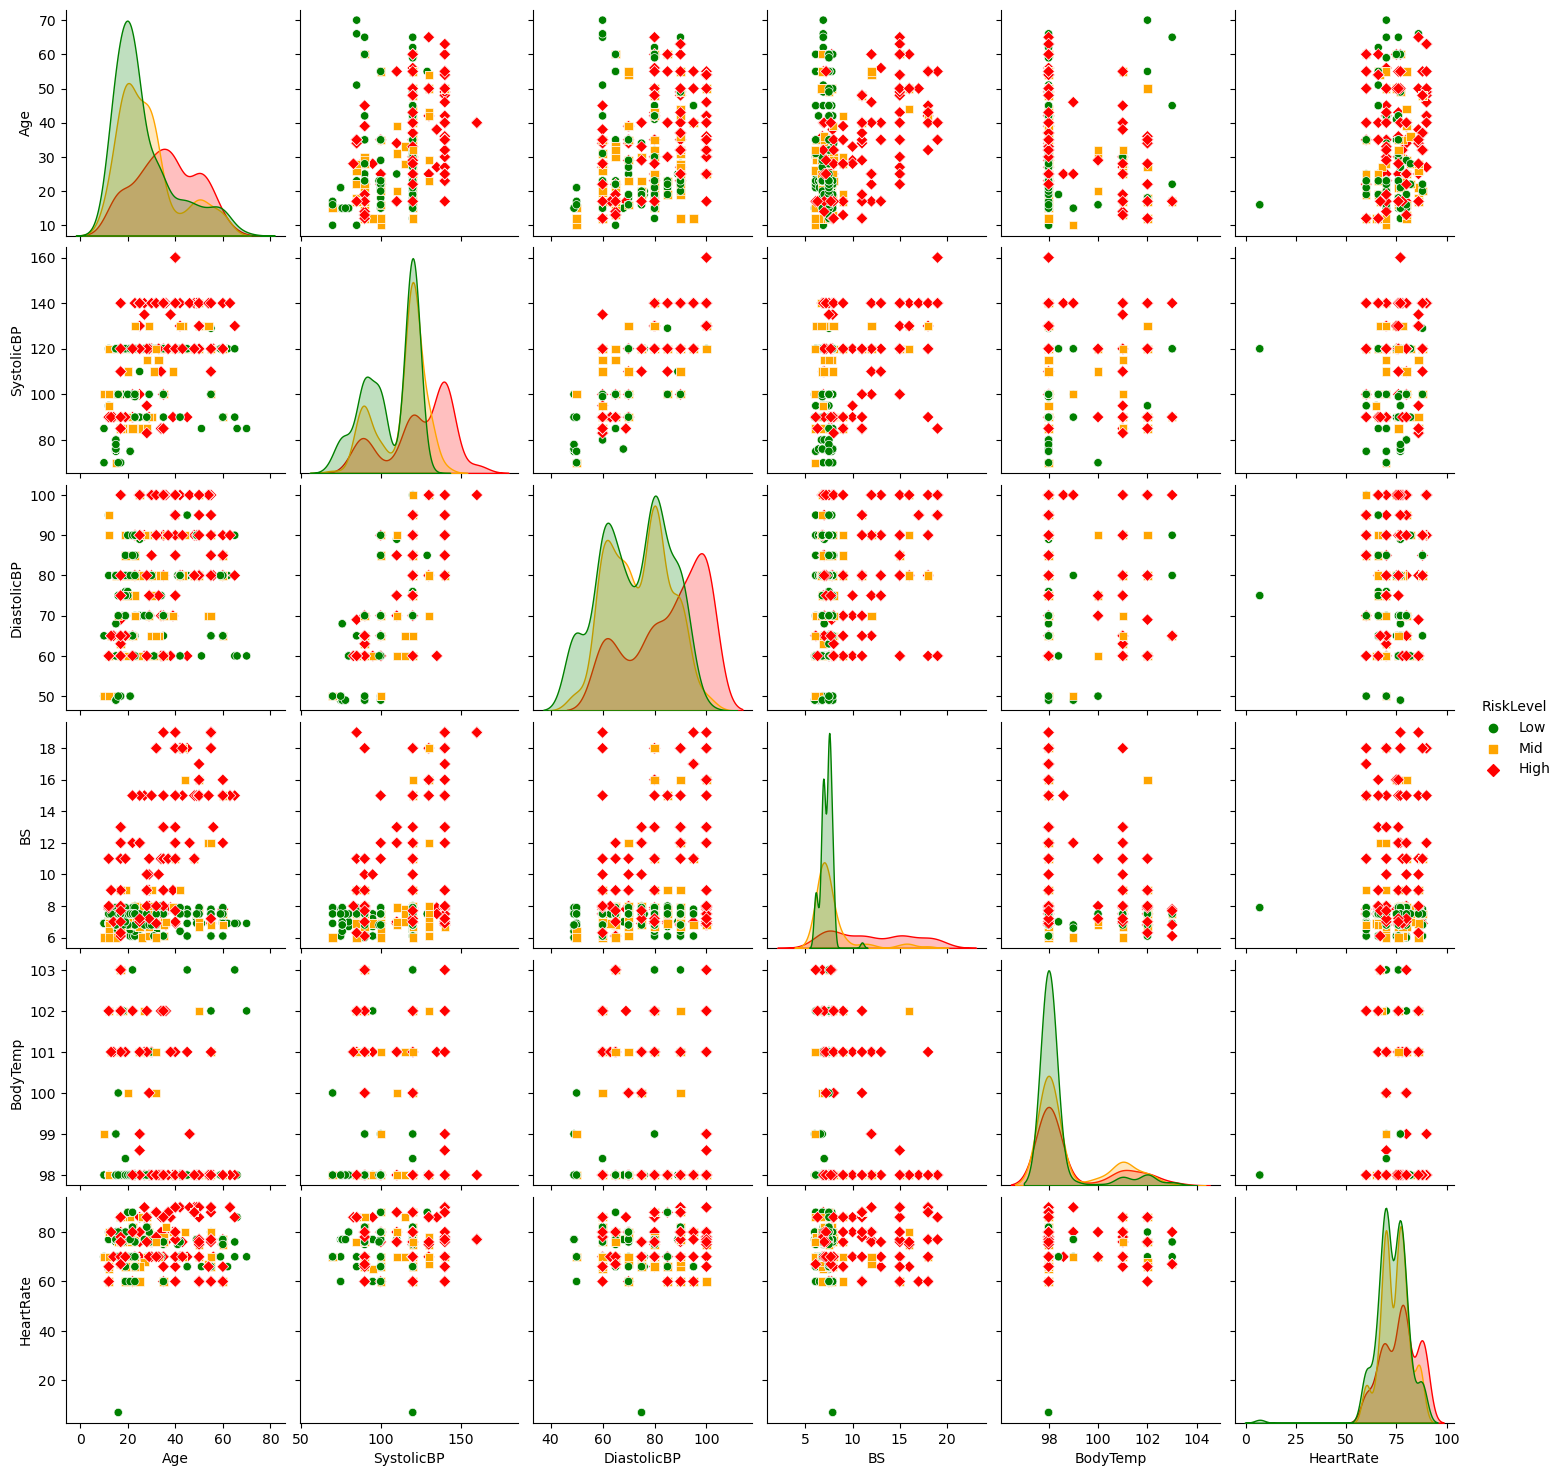

In [12]:
# Create a pairplot with RiskLevel
risk_colors = {0: "green", 1: "orange", 2: "red"}

plot = sns.pairplot(m_df, hue='RiskLevel', 
                    palette=risk_colors, 
                    markers=["o", "s", "D"])

legend_labels = {"0": "Low", "1": "Mid", "2": "High"}
for text, label in zip(plot._legend.texts, legend_labels.values()):
    text.set_text(label)
plt.savefig("maternal_pairplot_to_see_patterns.png")
plt.show()

In [13]:
# Dealing with multicollinearity
# Variance Inflation Factor (VIF) calculation
X = m_df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


In [14]:
# Drop SystolicBP for model training
m_df = m_df.drop(["SystolicBP"], axis=1)

In [15]:
# Identify the outlier in HeartRate
m_df.HeartRate.sort_values().head()

908     7
499     7
702    60
783    60
784    60
Name: HeartRate, dtype: int64

In [16]:
# Remove the outlier in HeartRate
m_df = m_df.drop(m_df.index[m_df.HeartRate == 7])

In [17]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   DiastolicBP  1012 non-null   int64  
 2   BS           1012 non-null   float64
 3   BodyTemp     1012 non-null   float64
 4   HeartRate    1012 non-null   int64  
 5   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


<h3>Model Building</h3>

In [18]:
# Feature scaling
columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
scale_X = StandardScaler()
X = pd.DataFrame(scale_X.fit_transform(m_df.drop(["RiskLevel"], axis = 1)), columns = columns)
y = m_df["RiskLevel"]

In [19]:
joblib.dump(scale_X, 'scaleX.pkl')
X.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.363796,0.254566,1.903633,-0.485808,1.538308
1,0.378765,0.974379,1.296644,-0.485808,-0.589878
2,-0.066772,-0.465247,-0.220828,0.972192,0.740239
3,0.007484,0.614473,-0.524323,-0.485808,-0.589878
4,0.378765,-1.185059,-0.797468,-0.485808,0.208192


In [20]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 5), (203, 5), (809,), (203,))

**Logistic Regression**

In [21]:
# Baseline model of Logistic Regression
logistic_regression = linear_model.LogisticRegression()
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
print(f"Baseline Logistic Regression: {round(logistic_regression_mod.score(X_test, y_test), 3)}")
pred_logistic_regression = logistic_regression_mod.predict(X_test)

Baseline Logistic Regression: 0.64


In [22]:
# Cross validate Logistic Regression model
scores_Logistic = cross_val_score(logistic_regression, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for Logistic Regression model:\n{scores_Logistic}")
print(f"CrossValMeans: {round(scores_Logistic.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_Logistic.std(), 3)}")

Scores(Cross validate) for Logistic Regression model:
[0.6037037  0.5962963  0.57992565]
CrossValMeans: 0.593
CrossValStandard Deviation: 0.01


In [23]:
params_LR = {"tol": [0.0001,0.0002,0.0003],
            "C": [0.01, 0.1, 1, 10, 100],
            "intercept_scaling": [1, 2, 3, 4],
            "solver": ["liblinear", "lbfgs", "newton-cg"],
            "max_iter": [100, 200, 300],
              }

In [24]:
GridSearchCV_LR = GridSearchCV(estimator=linear_model.LogisticRegression(), 
                                param_grid=params_LR, 
                                cv=3,
                                scoring="accuracy", 
                                return_train_score=True,
                                )

In [25]:
GridSearchCV_LR.fit(X_train, y_train);

In [26]:
print(f"Best estimator for LR model:\n{GridSearchCV_LR.best_estimator_}")
print(f"Best parameter values for LR model:\n{GridSearchCV_LR.best_params_}")
print(f"Best score for LR model: {round(GridSearchCV_LR.best_score_, 3)}")

Best estimator for LR model:
LogisticRegression(C=0.01, solver='liblinear')
Best parameter values for LR model:
{'C': 0.01, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best score for LR model: 0.602


In [27]:
# Test with new parameter
logistic_regression = linear_model.LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver="liblinear", tol=0.0001, random_state=42)
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
pred_logistic_regression = logistic_regression_mod.predict(X_test)

mse_logistic_regression = mean_squared_error(y_test, pred_logistic_regression)
rmse_logistic_regression = np.sqrt(mean_squared_error(y_test, pred_logistic_regression))
score_logistic_regression_train = logistic_regression_mod.score(X_train, y_train)
score_logistic_regression_test = logistic_regression_mod.score(X_test, y_test)

In [28]:
print(f"Mean Square Error for Logistic Regression = {round(mse_logistic_regression, 3)}")
print(f"Root Mean Square Error for Logistic Regression = {round(rmse_logistic_regression, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_logistic_regression_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_logistic_regression_test, 3)}")

Mean Square Error for Logistic Regression = 0.512
Root Mean Square Error for Logistic Regression = 0.716
R^2(coefficient of determination) on training set = 0.609
R^2(coefficient of determination) on testing set = 0.635


In [29]:
print("Classification Report")
print(classification_report(y_test, pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_logistic_regression))

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.88      0.70        81
           1       0.56      0.21      0.30        67
           2       0.77      0.80      0.79        55

    accuracy                           0.64       203
   macro avg       0.64      0.63      0.60       203
weighted avg       0.63      0.64      0.59       203

Confusion Matrix:
[[71  6  4]
 [44 14  9]
 [ 6  5 44]]


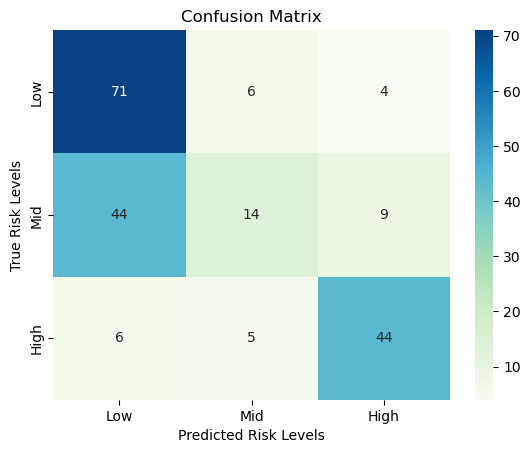

In [30]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_logistic_regression), annot=True, ax=ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");  
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

**K-Nearest Neighbors**

In [31]:
# Baseline model of K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_mod = knn.fit(X_train, y_train)
print(f"Baseline K-Nearest Neighbors: {round(knn_mod.score(X_test, y_test), 3)}")
pred_knn = knn_mod.predict(X_test)

Baseline K-Nearest Neighbors: 0.66


In [32]:
# Cross validate K-Nearest Neighbors model
scores_knn = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for K-Nearest Neighbors model:\n{scores_knn}")
print(f"CrossValMeans: {round(scores_knn.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_knn.std(), 3)}")

Scores(Cross validate) for K-Nearest Neighbors model:
[0.61481481 0.66666667 0.64684015]
CrossValMeans: 0.643
CrossValStandard Deviation: 0.021


In [33]:
params_knn = {"leaf_size": list(range(1,30)),
              "n_neighbors": list(range(1,21)),
              "p": [1,2],
              "weights": ["uniform", "distance"],
             }

In [34]:
GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(), 
                                param_grid=params_knn,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [35]:
# Fit model with train data
GridSearchCV_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [36]:
print(f"Best estimator for KNN model:\n{GridSearchCV_knn.best_estimator_}")
print(f"Best parameter values:\n{GridSearchCV_knn.best_params_}")
print(f"Best score for GNB model: {round(GridSearchCV_knn.best_score_, 3)}")

Best estimator for KNN model:
KNeighborsClassifier(leaf_size=1, n_neighbors=10, weights='distance')
Best parameter values:
{'leaf_size': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best score for GNB model: 0.795


In [37]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)

mse_knn = mean_squared_error(y_test, pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, pred_knn))
score_knn_train = knn_mod.score(X_train, y_train)
score_knn_test = knn_mod.score(X_test, y_test)

In [38]:
print(f"Mean Square Error for K_Nearest Neighbor  = {round(mse_knn, 3)}")
print(f"Root Mean Square Error for K_Nearest Neighbor = {round(rmse_knn, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_knn_test, 3)}")

Mean Square Error for K_Nearest Neighbor  = 0.251
Root Mean Square Error for K_Nearest Neighbor = 0.501
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.837


In [39]:
print("Classification Report")
print(classification_report(y_test, pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        81
           1       0.77      0.85      0.81        67
           2       0.88      0.93      0.90        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[62 17  2]
 [ 5 57  5]
 [ 4  0 51]]


[Text(0, 0.5, 'Low'), Text(0, 1.5, 'Mid'), Text(0, 2.5, 'High')]

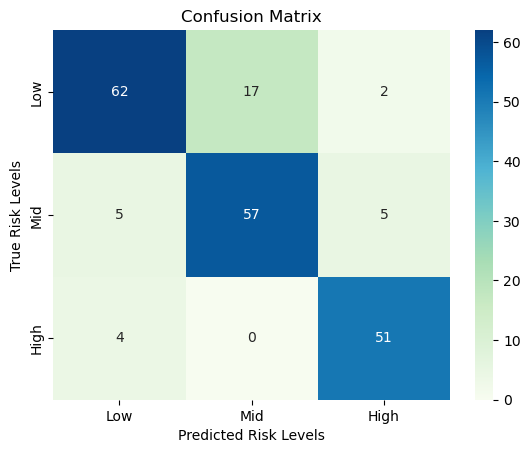

In [40]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels")
ax.set_ylabel("True Risk Levels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Low", "Mid", "High"])
ax.yaxis.set_ticklabels(["Low", "Mid", "High"])

**Random Forest**

In [41]:
# Baseline model of Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest_mod = random_forest.fit(X_train, y_train)
print(f"Baseline Random Forest: {round(random_forest_mod.score(X_test, y_test), 3)}")
pred_random_forest = random_forest_mod.predict(X_test)

Baseline Random Forest: 0.837


In [42]:
# Cross validate Random Forest Classifier model
scores_RF = cross_val_score(random_forest, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Random forest model:\n{scores_RF}")
print(f"CrossValMeans: {round(scores_RF.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_RF.std(), 3)}")

Scores(Cross validate) for Random forest model:
[0.81481481 0.8037037  0.82899628]
CrossValMeans: 0.816
CrossValStandard Deviation: 0.01


In [43]:
params_RF = {"min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 2, 4],
              "n_estimators" :[50,100,200,300,400],
              "max_depth": [None, 10, 20, 30],
              "criterion": ["gini", "entropy"]             
              }

In [44]:
GridSearchCV_RF = GridSearchCV(estimator=RandomForestClassifier(), 
                                param_grid=params_RF,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [45]:
GridSearchCV_RF.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 6, 20],
                         'n_estimators': [50, 100, 200, 300, 400]},
             return_train_score=True, scoring='accuracy')

In [46]:
print(f"Best estimator for RF model:\n{GridSearchCV_RF.best_estimator_}")
print(f"Best parameter values for RF model:\n{GridSearchCV_RF.best_params_}")
print(f"Best score for RF model: {round(GridSearchCV_RF.best_score_, 3)}")

Best estimator for RF model:
RandomForestClassifier(n_estimators=50)
Best parameter values for RF model:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score for RF model: 0.82


In [47]:
# Test with new parameter
random_forest = RandomForestClassifier(criterion="entropy", max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
random_forest_mod = random_forest.fit(X_train, y_train)
pred_random_forest = random_forest_mod.predict(X_test)

mse_random_forest = mean_squared_error(y_test, pred_random_forest)
rmse_random_forest = np.sqrt(mean_squared_error(y_test, pred_random_forest))
score_random_forest_train = random_forest_mod.score(X_train, y_train)
score_random_forest_test = random_forest_mod.score(X_test, y_test)

In [48]:
print(f"Mean Square Error for Random Forest = {round(mse_random_forest, 3)}")
print(f"Root Mean Square Error for Random Forest = {round(rmse_random_forest, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_random_forest_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_random_forest_test, 3)}")

Mean Square Error for Random Forest = 0.236
Root Mean Square Error for Random Forest = 0.486
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.837


In [49]:
print("Classification Report")
print(classification_report(y_test, pred_random_forest))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_random_forest))

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        81
           1       0.79      0.79      0.79        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[64 14  3]
 [ 9 53  5]
 [ 2  0 53]]


[Text(0, 0.5, 'Low'), Text(0, 1.5, 'Mid'), Text(0, 2.5, 'High')]

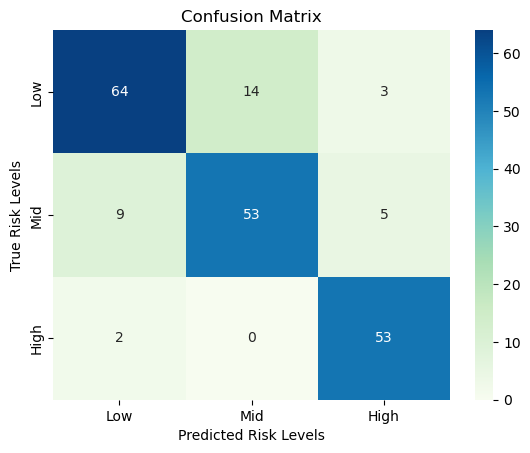

In [50]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_random_forest), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels")
ax.set_ylabel("True Risk Levels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Low", "Mid", "High"])
ax.yaxis.set_ticklabels(["Low", "Mid", "High"])

**Gradient Boosting Classifier**

In [51]:
# Baseline model of gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc_mod = gbc.fit(X_train, y_train)
print(f"Baseline gradient boosting classifier: {round(gbc_mod.score(X_test, y_test), 3)}")
pred_gbc = gbc_mod.predict(X_test)

Baseline gradient boosting classifier: 0.783


In [52]:
# Cross validate Gradient Boosting Classifier model
scores_GBC = cross_val_score(gbc, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Gradient Boosting Classifier model:\n{scores_GBC}")
print(f"CrossValMeans: {round(scores_GBC.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_GBC.std(), 3)}")

Scores(Cross validate) for Gradient Boosting Classifier model:
[0.74814815 0.78518519 0.80297398]
CrossValMeans: 0.779
CrossValStandard Deviation: 0.023


In [53]:
params_GBC = {"loss": ["deviance", "exponential"],
              "learning_rate": [0.01, 0.05, 0.075, 0.1], 
              "n_estimators": [100, 250, 500],
              "max_depth": [3, 5, 8, 10],
              "subsample": [0.8, 1],
              }

In [54]:
GridSearchCV_GBC = GridSearchCV(estimator=GradientBoostingClassifier(), 
                                param_grid=params_GBC,
                                cv=3,
                                scoring="accuracy", 
                                return_train_score=True
                                )

In [55]:
# Fit model with train data
GridSearchCV_GBC.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.075, 0.1],
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [100, 250, 500],
                         'subsample': [0.8, 1]},
             return_train_score=True, scoring='accuracy')

In [56]:
print(f"Best estimator values for GBC model:\n{GridSearchCV_GBC.best_estimator_}")
print(f"Best parameter values for GBC model:\n{GridSearchCV_GBC.best_params_}")
print(f"Best score value foe GBC model: {round(GridSearchCV_GBC.best_score_, 3)}")

Best estimator values for GBC model:
GradientBoostingClassifier(loss='deviance', max_depth=10, n_estimators=500,
                           subsample=1)
Best parameter values for GBC model:
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 500, 'subsample': 1}
Best score value foe GBC model: 0.824


In [57]:
# Test with new parameter
gbc = GradientBoostingClassifier(learning_rate=0.5, loss="deviance", max_depth=10, n_estimators=100, subsample=1,random_state=42)
gbc_mod = gbc.fit(X_train, y_train)
pred_gbc = gbc_mod.predict(X_test)

mse_gbc = mean_squared_error(y_test, pred_gbc)
rmse_gbc = np.sqrt(mean_squared_error(y_test, pred_gbc))
score_gbc_train = gbc_mod.score(X_train, y_train)
score_gbc_test = gbc_mod.score(X_test, y_test)

In [58]:
print(f"Mean Square Error for Gradient Boosting Classifier = {round(mse_gbc, 3)}")
print(f"Root Mean Square Error for Gradient Boosting Classifier = {round(rmse_gbc, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_gbc_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_gbc_test, 3)}")

Mean Square Error for Gradient Boosting Classifier = 0.232
Root Mean Square Error for Gradient Boosting Classifier = 0.481
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.842


In [59]:
print("Classification Report")
print(classification_report(y_test, pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_gbc))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        81
           1       0.80      0.79      0.80        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[65 13  3]
 [ 9 53  5]
 [ 2  0 53]]


[Text(0, 0.5, 'Low'), Text(0, 1.5, 'Mid'), Text(0, 2.5, 'High')]

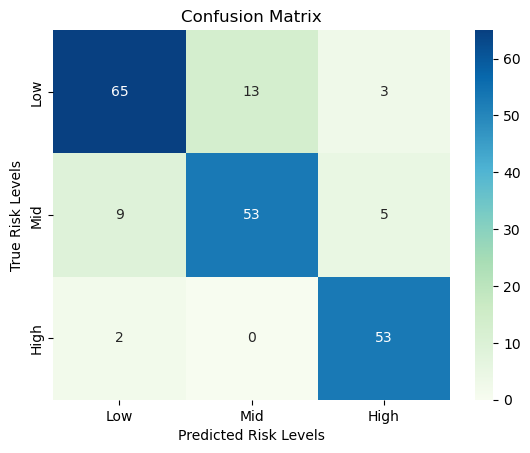

In [60]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_gbc), annot=True, ax = ax, cmap = "GnBu")

ax.set_xlabel("Predicted Risk Levels")
ax.set_ylabel("True Risk Levels") 
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Low", "Mid", "High"])
ax.yaxis.set_ticklabels(["Low", "Mid", "High"])

In [61]:
# Create a DataFrame to store model evaluation results
results = pd.DataFrame({
    "Model": ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", "Gradient Boosting Classifier"],
    "Train Score": [
        # Calculate mean cross-validated accuracy for training set
        cross_val_score(logistic_regression_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(knn_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(random_forest_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(gbc_mod, X_train, y_train, cv=3).mean(),
    ],
    "Test Score": [
        # Calculate accuracy on the test set
        logistic_regression_mod.score(X_test, y_test),
        knn_mod.score(X_test, y_test),
        random_forest_mod.score(X_test, y_test),
        gbc_mod.score(X_test, y_test),
    ]
})
# Additional Metrics (precision, recall, F1 score)
metrics = ["precision", "recall", "f1"]
for metric in metrics:
    results[f"{metric.capitalize()}"] = [
        precision_recall_fscore_support(y_test, model.predict(X_test), average="weighted")[metrics.index(metric)]
        for model in [logistic_regression_mod, knn_mod, random_forest_mod, gbc_mod]
    ]

result_df = results.sort_values(by="Test Score", ascending=False)
result_df = result_df.set_index("Test Score")
result_df


,Model,Train Score,Precision,Recall,F1
Test Score,,,,,
0.842365,Gradient Boosting Classifier,0.810891,0.841706,0.842365,0.841021
0.837438,K-Nearest Neighbors,0.794818,0.840899,0.837438,0.836922
0.837438,Random Forest,0.810891,0.836980,0.837438,0.836060
0.635468,Logistic Regression,0.601960,0.628104,0.635468,0.593824


In the evaluation of model performance, the Gradient Boosting Classifier emerges as the standout performer among the considered models. With a test accuracy of 84.23%, it surpasses both the K-Nearest Neighbors and Random Forest models, which exhibit commendable test accuracies of 83.74% each. Notably, the Gradient Boosting Classifier's test score outstrips its train score, indicating robust generalization and mitigating concerns of overfitting. Moreover, this model demonstrates superior precision, recall, and F1 score, reflecting a well-balanced performance across various evaluation metrics. The KNN model closely follows, excelling in precision and recall, while the Random Forest model performs well but shows a slight dip in precision. Conversely, the Logistic Regression model consistently lags in all metrics, highlighting its comparatively lower effectiveness. Consequently, the Gradient Boosting Classifier stands out as the preferred choice for this classification task, offering a compelling balance between precision, recall, and overall accuracy.

In [62]:
import pickle

In [63]:
pickle.dump(gbc_mod, open('finalized_maternal_model.sav', 'wb'))